# _Flow Shop Scheduling Problem_

__Lorenzo Famiglini__:

In [1127]:
import pandas as pd 
import numpy as np

In [1578]:
df = pd.read_table("/Users/lorenzofamiglini/Desktop/5machine_3job.txt", delim_whitespace = True, header = None)

In [1579]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,54,83,15,71,77,36,53,38,27,87,76,91,14,29,12,77,32,87,68,94
1,79,3,11,99,56,70,99,60,5,56,3,61,73,75,47,14,21,86,5,77
2,16,89,49,15,89,45,60,23,57,64,7,1,63,41,63,47,26,75,77,40
3,66,58,31,68,78,91,13,59,49,85,85,9,39,41,56,40,54,77,51,31
4,58,56,20,85,53,35,53,41,69,13,86,72,8,49,47,87,58,18,68,28


# _Makespan function:_

In [1554]:
def makespan2(df, column_range, sequence): #column_range, sequence
    df = df[sequence].T.reset_index(drop = True).T
    o = df.shape[1] #numero di operazioni
    m = df.shape[0] #numero di macchine
    mat = [[df[i][j] for i in column_range] for j in range(m)] #inizializzo la matrice 
    app = [[0 for j in range(o)]for i in range(m)] #in range del numero delle operazioni
    app[0][0] = df[0][0] #aggiungo il primo elemento prima riga prima colonna
    for i in range(0,m): #da 0 a n-macchine
        for j in range(0,o): #da 0 a n-jobs
            if  (app[i][j-1] >= app[i-1][j]): 
                app[i][j] = app[i][j-1] + mat[i][j]
            else:
                app[i][j] = app[i-1][j] + mat[i][j]
                
       # print(make)
    return(app[-1][-1]) #ultimo elemento dell'ultimo array

In [1580]:
makespan2(df, column_range = range(0,20), sequence = [18, 7, 14, 5, 16, 10, 15, 12, 2, 8, 17, 4, 0, 13, 11, 1, 3, 9, 6, 19])

1356

# Random Sequence Function

In [1556]:
def random_sequence_function(num_etichette, intervallo):
    import itertools
    global mylist_n
    seq = []
    for i in range(num_etichette):
        j = np.random.permutation(intervallo)
        for j in seq:
            j = np.random.permutation(intervallo)
        seq.append(j.tolist())
    #mylist_n = [j for i in seq for j in i] #rimuove la doppia lista
    return(seq)

# Score Function
Usiamo questa formula per calcolari la probabilità: k è il valore k-esimo di makespan, M è la mediana. Ho provato un metodo in cui si calcola il valore mediano ha una possibilità di $\frac{1}{M}$ di essere selezionato, mentre il $M^{th}$ (il più adatto) ha una possibilità di $\frac{2}{M+1}$, circa il doppio di quello della mediana: 
$ p(k) = \frac{2k}{M(M+1)} $. Ma alla fine $p(k) = \frac{f_i}{\sum_{j=1}^n{f_j}}$ risulta essere quella più accurata.
Questi valori ci servono per estrapolare le sequenze con uno score più alto, per poi essere immesse all'interno del crossover.

In [1557]:
def prob(diz): 
    dframe = pd.DataFrame(diz).T
    dframe["sum"] = dframe["makespan"].sum()
    #dframe["prob"] = (2*dframe["makespan"]/(dframe["median"]*(dframe["median"]+1)))*100
    #dframe["p(k)"] = (1 - dframe["prob"])
    dframe["fit"] = dframe["makespan"]/dframe["sum"]   #dframe["p(k)"] / dframe["p(k)"].sum()
    c = np.random.choice(dframe["sol"], len(dframe),p=dframe["fit"].tolist(), replace = True).tolist() #popolazione intermedia
    return c

# Shuffle function per il Crossover

In [1558]:
def fun_order(l):
    l = list(range(0, len(l)))
    ind = 1
    for i in (range(int(len(l)/2))):
        old = ind
        l[ind] = l[ind-1]
        l[ind-1] = old
        ind= ind + 2
    return(l)

# Crossover Phase

In [1559]:
def crossover(prova, crs):
    x = []
    diz = {}
    for i in prova: 
        s = i[:crs] #prendi i primi due elementi
        x.append(s)
    myorder = fun_order(x)
    x = [x[i] for i in myorder]
    for i in range(len(x)): 
        diz["sol {0}".format(i)] = x[i]
        for j in range(len(prova[0])):
            if prova[i][j] not in diz["sol {0}".format(i)]:
                diz["sol {0}".format(i)].append(prova[i][j])
    return(diz)
# la probabilità di crossover è sempre uno, possiamo decidere quanti elementi devono essere presi in considerazione.

# Selection + Crossover Phase

In [1560]:
def selection_crossover(df, num_etichette, intervallo, column_range, c, crs): 
    lista = []
    diz = {}
    l = []
    lista.append(c)
    conta = 0
    mylist_p = [j for i in lista for j in i]
    for i in mylist_p:
        d = {}
        d["sol"] = i
        d["makespan"] = makespan2(df,column_range, sequence = i) #funzione del makespan
        #case = {'sol': i, 'makespan': makespan2(df,column_range, sequence = i)}
        diz["sol{0}".format(conta)] = d
        conta = conta+1
    q = prob(diz) #funzione probability
    c = crossover(q, crs) #funzione del cross over
    return c

# Mutate Phase

In [1561]:
def mutate(diz, change_probability):
    lista = []
    import random
    for key, value in diz.items():
        lista.append(value)
    for i in range(len(lista)):
        if(random.random() < change_probability):
            scambia = int(random.random() * len(lista))
            p1 = lista[i]
            p2 = lista[scambia]
            lista[i] = p2
            lista[scambia] = p1
    return (lista)

Change probability è la probilità che i nuovi geni subiscono una mutazione. Dalla letteratura si consiglia un valore compreso tra  [0.001, 0.01].

In [1562]:
mut = mutate(a, 0.01)

# Genetic Algorithm

In [1563]:
def GeneticAlgorithm(df,num_etichette, intervallo, column_range, chance_prob, n_iter, crs):
    c = random_sequence_function(num_etichette, intervallo)
    diz = {}
    conta = 0
    app = {}
    conta2 = 0
    minimo = 10000000
    it = 0 
    conta3 = 0
    lista = []
    for i in range(0,n_iter):
        ass = selection_crossover(df, num_etichette, intervallo, column_range, c=c, crs = crs)
        ass = mutate(ass, chance_prob)
        for j in ass:
            app2 = {}
            app2["sol"] = j
            app2["makespan"] = makespan2(df, column_range,j)
            a = app["sol{0}".format(conta2)] = app2
            conta2 = conta2 + 1
            if a["makespan"] < minimo: #potremmo perdere il miglior valore quindi applichiamo l'iterismo
                minimo = a["makespan"]
                sec = a["sol"]
                diz3["makespan"] = minimo
                diz3["solution"] = sec
                diz3["iterazione"] = conta3
                conta3 = conta3 + 1
    for i in ass: 
        d = {}
        d["sol"] = i
        d["makespan"] = makespan2(df, column_range, i)
        d["iterazione"] = it
        diz["sol{0}".format(conta)] = d
        conta = conta + 1
        it = it + 1
    diz = pd.DataFrame(diz).T
    diz = diz.sort_values(by=['makespan']).head(10)
    return diz, diz3

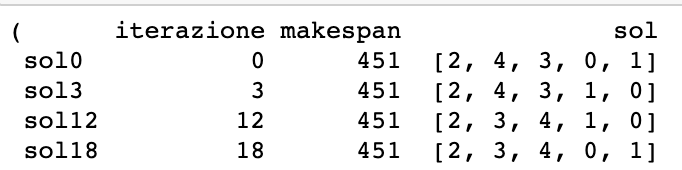

In [1564]:
from IPython.display import Image
img = '/Users/lorenzofamiglini/Desktop/img.png'
Image(filename=img)

Riprendendo l'esempio dell'assignment, il mio algoritmo con 100 iterazioni riesce a raggiungere lo stesso risultato ottimale 451, anzi abbiamo diverse combinazioni per poterlo raggiungere:
    [2,3,4,0,1], [2,4,3,1,0], [2,3,4,1,0], [2,3,4,0,1].

In [1565]:
GeneticAlgorithm(df,num_etichette = 20, intervallo = 20, column_range = range(0,20) , chance_prob = 0.1, n_iter =200, crs = 5)

(      iterazione makespan                                                sol
 sol16         16     1437  [3, 12, 1, 7, 14, 16, 11, 19, 2, 9, 15, 0, 5, ...
 sol0           0     1439  [12, 0, 17, 11, 8, 10, 9, 18, 13, 14, 15, 5, 2...
 sol6           6     1444  [14, 6, 18, 16, 2, 19, 0, 8, 5, 12, 13, 9, 1, ...
 sol12         12     1459  [12, 10, 11, 4, 1, 14, 16, 7, 19, 2, 9, 15, 0,...
 sol3           3     1480  [19, 7, 0, 15, 2, 10, 8, 4, 9, 18, 14, 17, 1, ...
 sol15         15     1485  [12, 0, 17, 11, 8, 10, 2, 4, 9, 18, 14, 1, 7, ...
 sol18         18     1485  [2, 7, 1, 0, 17, 10, 8, 4, 9, 18, 14, 5, 6, 19...
 sol4           4     1491  [14, 16, 7, 11, 19, 3, 12, 1, 6, 2, 10, 5, 18,...
 sol10         10     1497  [19, 7, 0, 15, 2, 4, 10, 12, 1, 14, 11, 13, 6,...
 sol5           5     1498  [16, 15, 5, 14, 6, 12, 10, 11, 4, 1, 17, 18, 1...,
 {'makespan': 1355,
  'solution': [16,
   15,
   5,
   14,
   6,
   10,
   4,
   7,
   0,
   17,
   3,
   2,
   8,
   11,
   1,
   12,
   13,

# Neh Algorithm: 

Dobbiamo generalizzare ancora di più il makespan: 

In [1566]:
def makespan(df, sequence): #column_range, sequence
    df = df[sequence].T.reset_index(drop = True).T
    o = df.shape[1] #numero di operazioni
    m = df.shape[0] #numero di macchine
    mat = [[df[i][j] for i in range(len(sequence))] for j in range(m)] #inizializzo la matrice 
    app = [[0 for j in range(len(sequence))]for i in range(m)] #in range del numero delle operazioni
    app[0][0] = df[0][0] #aggiungo il primo elemento prima riga prima colonna
    for i in range(0,m): #da 0 a n-macchine
        for j in range(0,len(sequence)): #da 0 a n-jobs
            if  (app[i][j-1] >= app[i-1][j]): 
                app[i][j] = app[i][j-1] + mat[i][j]
            else:
                app[i][j] = app[i-1][j] + mat[i][j]
                
       # print(make)
    return(app[-1][-1]) #ultimo elemento dell'ultimo array

# Improved Heuristic: 
L'euristica migliorata proposta per il FSSP produce risultati migliori rispetto all'algoritmo originale NEH mantenendo la stessa complessità algoritmica. L'euristica implementata genera un numero maggiore di sequenze minime di makespan rispetto all'algoritmo NEH classico e quindi abbiamo più opzioni di sequenze di lavoro che possono essere implementate per una maggiore produzione.

# Init_perm function()
E' una funzione che ci calcola 4! possibili permutazioni per i primi 4 jobs. Da queste combinazioni si selezionanto le migliori n soluzioni (0 < n < 25) (makespane in ordine crescente, quindi avremmo le varie combinazioni che minimizzano tale funzione).

In [1567]:
def init_perm (df,int_perm):
    from itertools import permutations 
    l = list(permutations(int_perm))
    l = np.array(l).tolist()
    app = {}
    conta = 0
    for i in l:
        app2 = {}
        app2["sol"] = i
        app2["makespan"] = makespan(df,i)
        app["sol{0}".format(conta)] = app2
        conta = conta + 1
    sor = dict(sorted(app.items(), key=lambda item: item[1]['makespan'])[:6])
    lista = []
    for key, value in sor.items():
        lista.append(value["sol"])
    return lista

# In_list function:
All'interno della funzione in_list aggiungiamo job + 1 e ricalcoliamo il tutto prendendo sempre i migliori. 

In [1568]:
def in_list(lista, conta): 
    best_l = []
    best_fit = 5000000
    for i in range(len(lista) + 1):
        lista2 = lista.copy()
        lista2.insert(i, conta) 
        app2 = {}
        app2["sol"] = lista2
        app2["fit"] = makespan(df, lista2)
        if app2["fit"] < best_fit:
            lista3 = []
            best_fit = app2["fit"]
            lista3.append(app2["sol"])
        mylist_n = [j for i in lista3 for j in i] #rimuove la doppia lista
    return mylist_n

# Cycle:
Con tale funzione iteriamo aggiungendo ad ogni iterazioni un job in più, fino ad arrivare alla soluzione "ottimale".

In [1569]:
def cycle(lista, conta):
    c = []
    for i in lista:
        c.append(in_list(i, conta))
    return c

# Neh algorithm funzione finale: 

In [1570]:
def neh_algorithm(df, li, conta): 
    for i in range(len(df.columns) -4):
        li = cycle(li,conta)
        conta = conta + 1
    up = 0
    app = {}
    for j in li: 
        app2 = {}
        app2["sol"] = j
        app2["fit"] = makespan(df, j)
        app["sol{0}".format(up)] = app2
        up = up + 1 
    app = pd.DataFrame(app).reset_index().T
    return app 

In [1571]:
li = init_perm(df, range(0,4))

In [1574]:
neh = neh_algorithm(df, li, conta = 4)

# Implementazione Neh + Ga

• Anzichè far partire il GA da una popolazione casuale, viene inizializzato con il risultato del NEH.

In [1538]:
def neh_algorithm2(df, li, conta): 
    lista12 = []
    for i in range(len(df.columns) -4):
        li = cycle(li,conta)
        conta = conta + 1
    up = 0
    app = {}
    for j in li: 
        app2 = {}
        app2["sol"] = j
        app2["fit"] = makespan(df, j)
        app["sol{0}".format(up)] = app2
        up = up + 1 
    neh = pd.DataFrame(app).reset_index().T
    neh = neh[(neh[0] != 0) & (neh[1] != 9) & (neh[0] != "fit") & (neh[1] != "sol")][1]
    for i in neh:
        lista12.append(i)
    return  lista12

In [1539]:
def selection_crossover2(df, intervallo, column_range, crs, mylist_p): 
    diz = {}
    l = []    
    conta = 0
    for i in mylist_p:
        d = {}
        d["sol"] = i
        d["makespan"] = makespan2(df,column_range, sequence = i) #funzione del makespan
        diz["sol{0}".format(conta)] = d
        conta = conta+1
    q = prob(diz) #funzione probability
    c = crossover(q, crs) #funzione del cross over
    return c

In [1572]:
def NehGA(df, intervallo, column_range , chance_prob, n_iter, crs, conta):
    li = init_perm(df, range(0,4))
    mylist_p = neh_algorithm2(df, li, conta)
    diz = {}
    conta = 0
    app = {}
    conta2 = 0
    minimo = 10000000
    it = 0 
    conta3 = 0
    lista = []
    best = []
    for i in range(0,n_iter):
        ass = selection_crossover2(df, intervallo, column_range, mylist_p = mylist_p, crs = crs)
        ass = mutate(ass, chance_prob)
        for j in ass:
            app2 = {}
            app2["sol"] = j
            app2["makespan"] = makespan2(df, column_range,j)
            a = app["sol{0}".format(conta2)] = app2
            conta2 = conta2 + 1
            if a["makespan"] < minimo: #during the iterations we may lose the best value, so we can save it here. 
                minimo = a["makespan"]
                sec = a["sol"]
                diz3["makespan"] = minimo
                diz3["solution"] = sec
                diz3["iterazione"] = conta3
                conta3 = conta3 + 1
    for i in ass: 
        d = {}
        d["sol"] = i
        d["makespan"] = makespan2(df, column_range, i)
        d["iterazione"] = it
        diz["sol{0}".format(conta)] = d
        conta = conta + 1
        it = it + 1
    diz = pd.DataFrame(diz).T
    diz = diz.sort_values(by=['makespan']).head(10)
    return diz, diz3, best


In [1573]:
NehGA(df, intervallo = 20, column_range = range(0,20) , chance_prob = 0.1  , n_iter = 200, crs = 5, conta = 4)

(     iterazione makespan                                                sol
 sol1          1     1297  [16, 14, 13, 15, 10, 8, 12, 5, 17, 3, 1, 0, 2,...
 sol3          3     1297  [16, 8, 14, 15, 5, 10, 13, 7, 2, 3, 1, 0, 4, 1...
 sol4          4     1297  [16, 14, 13, 15, 10, 8, 5, 17, 0, 3, 1, 7, 4, ...
 sol5          5     1297  [16, 14, 13, 15, 10, 8, 5, 17, 0, 3, 1, 7, 4, ...
 sol0          0     1321  [10, 8, 14, 16, 12, 13, 15, 5, 17, 0, 3, 1, 7,...
 sol2          2     1355  [16, 10, 8, 14, 15, 5, 18, 0, 2, 17, 3, 1, 7, ...,
 {'makespan': 1297,
  'solution': [16,
   10,
   8,
   14,
   15,
   5,
   13,
   7,
   2,
   3,
   1,
   0,
   4,
   17,
   9,
   6,
   11,
   18,
   12,
   19],
  'iterazione': 0},
 [])

# _Vediamo i risultati dei vari algoritmi implementati:_
NB: i test sono stati mandati più di una volta proprio per verificare la validità del risultato. 
    
# Lavorando su una matrice: 20 x 50 (20 macchine e 50 jobs)
- GA: la migliore soluzione che raggiunge è pari a: 4516 (con 100 iterazioni e prob. di mutazione: 0.01 e crossover 1/10)
- Neh: la migliore soluzione è pari a: 4053 
- Ga + Neh: anzichè partire da una popolazione casuale, partiamo dalle migliori 20 soluzioni del Neh per poi applicare direttamente tali soluzioni con una probabilità di mutazione pari a 0.09 con 100 iterazioni e crossover sempre pari a 1/17 della lunghezza dei jobs: i risultati sono molto soddisfacienti: il makespan raggiunge __4038__ con una sequenza pari a: [34,19,14,30,5,6,23,44,9,41,37,42,45,32,38,4,27,33,28,10,26,0,36,39,21,16,13,29,3,20,17,7,15,46,31,1,22,35,18,25,43,12,49,48,40,11,8,47,24,2].

__Quindi in questo caso possiamo concludere che l'implementazione GA + Neh risulta essere la più efficiente, ovviamente ci avviciniamo di più all'upper bound della soluzione ottimale che è pari a 3875__

# Lavorando su una matrice: 5 x 20 (5 macchine e 20 jobs): 
- GA: makespan = 1346 (100 iterazioni, prob. di mutazione: 0.01, crossover pari a 1/10)
- Neh: makespan = 1297
- GA + Neh: makespan = __1297__, uguale al Neh ma otteniamo 10 combinazioni possibili per ottenere tale risultato (100 iterazioni, prob. di mutazione: 0.01, crossover pari a 1/10) 

__L'upper bound della soluzione ottimale in questo caso è  1278__

# Lavorando su una matrice: 10 x 100 (10 macchine e 100 jobs): 
- GA: makespan = 6497 (500 iterazioni, prob. di mutazione: 0.01, crossover pari a 1/10)
- Neh: makespan = 5865
- GA + Neh: makespan = __5865__, uguale al Neh ma con un'altra combinazione, le ultime etichette mutate variano tra 5905 e 5958 mentre nel GA variano tra 6603 - 6906. Quindi anche qui possiamo dire che è notevolemente migliorato (100 iterazioni, prob. di mutazione: 0.01, crossover pari a 1/10). 

__L'upper bound della soluzione ottimale è pari a: 5770__

# Lavorando su una matrice: 20 x 20 (20 macchine e 20 jobs): 
- GA: makespan = 2556 (100 iterazioni, prob. di mutazione: 0.01, crossover pari a 1/10)
- Neh: makespan = 2362
- GA + Neh: makespan = __2350__, è il risultato migliore tra tutti i vari algoritimi(100 iterazioni, prob. di mutazione: 0.01, crossover pari a 1/10), con una sequenza di lavoro pari a: [15,7,6,12,8,13,0,19,4,11,17,14,9,2,16,10,1,5,3,18]. Ancora una volta l'implementazione tra i due migliora la soluzione. 

__L'upper bound della soluzione ottimale è pari a: 2297__

# Lavorando su una matrice: 10 x 20 (10 macchine e 20 jobs): 
- GA: makespan = 1926 (100 iterazioni, prob. di mutazione: 0.01, crossover pari a 1/10)
- Neh: makespan = 1720
- Ga + Neh: si nota un leggero miglioramento, con un makespan: __1717__, e una sequenza: [16,11,18,14,4,10,19,6,3,9,8,12,1,15,0,5,7,13,2,17]. 

Il crossover in questo caso prende le ultime 3 e le permuta tra le varie coppie di sequenze. 

__L'upper bound della soluzione ottimale è pari a: 1659__


# Lavorando su una matrice: 5 x 50 (50 macchine e 5 jobs): 
- GA: makespan = 2843 (100 iterazioni, prob. di mutazione: 0.01, crossover pari a 1/10)
- Neh: makespan = __2724__ (abbiamo più combinazioni con 2724), un grande risultato dal momento che l'upper bound è esattamente 2724. La sequenza è pari a (ne mostro solo una delle varie): 
[30, 49, 40, 47, 39, 43, 48, 41, 42, 38, 37, 16, 44, 33, 31, 25, 26, 17, 32, 27, 45, 34, 36, 9, 46, 2, 24, 22, 21, 23, 20, 12, 0, 5, 10, 3, 11, 1, 4, 28, 7, 29, 13, 8, 14, 6, 15, 19, 18, 35]
- Ga + Neh: per la prima volta si nota un leggero peggioramento ottenendo una soluzione di makespan pari a 2729, quindi in questo caso è meglio la semplice implementazione Neh. 

__L'upper bound della soluzione ottimale è pari a: 2724__

# Confrontiamo il GA con la libreria "pyeasega": 

In [1549]:
import random
from pyeasyga import pyeasyga



data=list(range(df.shape[1]))


ga = pyeasyga.GeneticAlgorithm(data,
                            population_size=200,
                            generations=100,
                            crossover_probability=0.8,
                            mutation_probability=0.1,
                            elitism=True,
                            maximise_fitness=True)


def create_individual(data):
    individual = data[:]
    random.shuffle(individual)
    return individual

ga.create_individual = create_individual


def crossover(parent_1, parent_2):
    crossover_index = random.randrange(1, len(parent_1))
    child_1a = parent_1[:crossover_index]
    child_1b = [i for i in parent_2 if i not in child_1a]
    child_1 = child_1a + child_1b

    child_2a = parent_2[crossover_index:]
    child_2b = [i for i in parent_1 if i not in child_2a]
    child_2 = child_2a + child_2b
    
    return child_1, child_2

ga.crossover_function = crossover

# define and set the GA's mutation operation
def mutate(individual):
    mutate_index1 = random.randrange(len(individual))
    mutate_index2 = random.randrange(len(individual))
    individual[mutate_index1], individual[mutate_index2] = individual[mutate_index2], individual[mutate_index1]

ga.mutate_function = mutate

def selection(population):
    #print(population)
    
    return random.choice(population)

ga.selection_function = selection

# define a fitness function
def fitness (individual, data):
    fitness=0
    v= makespan2(df,range(0,20),np.array(individual, dtype="int32"))
    fitness+= 1/v
    return fitness
ga.fitness_function = fitness    

In [1550]:
ga.run()

In [1551]:
ga.best_individual()

(0.0007593014426727411,
 [14, 5, 18, 7, 15, 16, 10, 12, 2, 8, 17, 4, 0, 13, 11, 1, 3, 9, 6, 19])

In [ ]:
[11,23,48,40,20,15,1,26,38,19,42,12,31,13,7,6,34,33,17,29,37,5,14,30,18,35,41,47,28,32,9,16,39,3,36,45,10,43,46,22,24,0,2,4,21,44,8,25,27,49]

In [1552]:
makespan2(df, range(0,20),[14, 5, 18, 7, 15, 16, 10, 12, 2, 8, 17, 4, 0, 13, 11, 1, 3, 9, 6, 19])

1317

# GA vs GA library: 
• 200 iterazioni con probabilità di mutazione pari a 0.1: 
# Lavorando su una matrice: 5 x 50 (50 macchine e 5 jobs)
- GA: __2928__
- GA library: __2774__, sequenza: [16,4,25,41,36,35,39,40,26,38,46,24,17,31,45,2,34,44,5,3,11,14,30,27,28,48,20,37,1,32,8,23,49,6,12,33,13,43,19,7,29,42,9,47, 18,21,22,0,10,15]
- GA + Neh: __2729__, sequenza:[30,49,40,45,39,42,41,33,44,48,43,38,37,31,25,23,16,17,36,27,29,21,24,28,26,46,32,22,47,20,9,5,2,12,1,4,7,13,0,3,6,10,14,11,8,18,15,19,35,34]

La libreria lavora meglio rispetto al GA implementato da me, ma GA + Neh, raggiunge risultati migliori del pacchetto. 

# Lavorando su una matrice: 20 x 50 (20 macchine e 50 jobs)
- GA: makespan = 4680
- GA library: 4410, sequenza: [11,23,48,40,20,15,1,26,38,19,42,12,31,13,7,6,34,33,17,29,37,5,14,30,18,35,41,47,28,32,9,16,39,3,36,45,10,43,46,22,24,0,2,4,21,44,8,25,27,49]
- GA + Neh: 4053, sequenza: 
[19,30,14,5,6,23,44,9,41,37,42,45,32,38,4,27,33,28,10,26,0,36,39,21,16,13,34,29,3,20,17,7,15,46,31,1,22,35,18,25,43,12,49,48,40,11,8,47,24,2]


# Lavorando su una matrice: 5 x 20 (5 macchine e 20 jobs)
- GA: makespan = 1355
- GA library: 1317, con una sequenza: [14, 5, 18, 7, 15, 16, 10, 12, 2, 8, 17, 4, 0, 13, 11, 1, 3, 9, 6, 19]
- GA + Neh: 1297, con una sequenza: [16,10,8,14,15,5,13,7,2,3,1,0,4,17,9,6,11,18,12,19] (varie combinazioni)

# _Conclusioni:_

Dopo aver confrontato i vari algoritimi, sono giunto a varie conclusioni: 
In primo luogo, il GA implementato da me non ottiene grandi risultati (soprattutto se messo a confronto con la libreria pyeasega), i risultati si avvicinano all'upper bound (in certi casi) ma non riesce ad essere così ottimale. L'algoritmo Neh di base produce dei risultati migliori sia della libreria sia dell'algoritmo implementato da me. Alla fine ho deciso di implementare l'algoritmo genetico con il Neh in modo tale da avere un buon punto di partenza (anzichè avere delle combinazioni casuali). Questo ha fatto si che i risultati ottenuti sono notevolemente migliorati, anzi nel caso di una matrice di 5 macchine e 50 jobs si riesce a raggiungere esattamente l'upper bound della soluzione ottimale. 
Generalmente ci avviciniamo all'upper bound senza riuscire a essere all'interno dell'intervallo della soluzione ottimale. In altre parole, la libreria lavora leggermente meglio dell'algoritmo implementato, ma se lo confrontiamo con Ga + Neh, i risultati sono meno efficienti. Quindi posso ritenermi soddisfatto nell'aver costruito questa funzione più complessa. 